# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [5]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv

def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

In [8]:
img = cv2.imread('drive/MyDrive/ColabNotebooks/birds.jpeg') # считать картинку

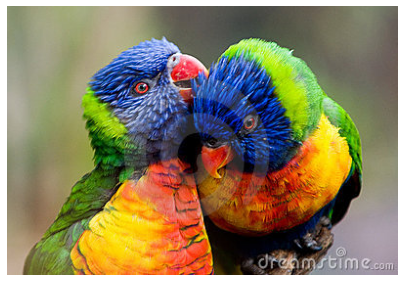

In [9]:
draw_picture(img) # нарисовать картинку

In [10]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [11]:
one_dim_img = img.reshape(-1, 3)
one_dim_img.shape

(110000, 3)

In [12]:
from skimage.metrics import structural_similarity as ssim

Рассмотрим кластеризацию KMeans:

In [13]:
from sklearn.cluster import KMeans

In [14]:
kmeans = KMeans(n_clusters=2)
y_preds = kmeans.fit_predict(one_dim_img)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

In [15]:
centers[labels].shape

(110000, 3)

In [16]:
predict_picture = centers[labels].reshape(275, 400, 3).astype('u1')

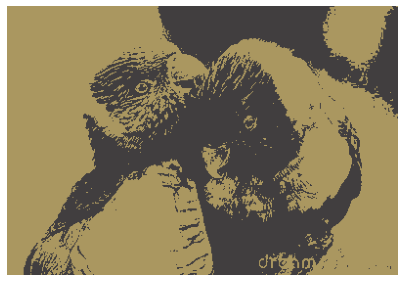

In [17]:
draw_picture(predict_picture)

In [18]:
ssim(img, predict_picture, multichannel=True)

0.5334921736948373

Напишем универсальную функцию:

In [19]:
def kmeans_clustering_img(n_clust=2):
  kmeans = KMeans(n_clusters=n_clust)
  y_preds = kmeans.fit_predict(one_dim_img)
  centers = kmeans.cluster_centers_
  labels = kmeans.labels_
  predict_picture = centers[labels].reshape(275, 400, 3).astype('u1')
  draw_picture(predict_picture)
  print(ssim(img, predict_picture, multichannel=True))

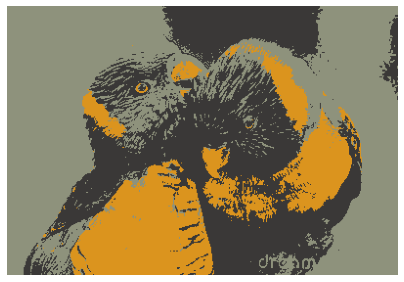

0.5634521498549238


In [20]:
kmeans_clustering_img(3)

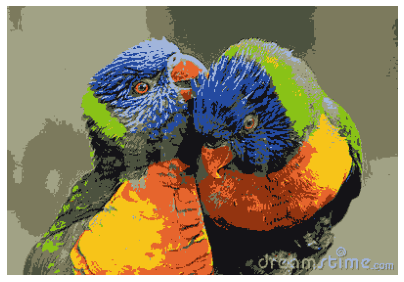

0.6787751236118834


In [21]:
kmeans_clustering_img(10)

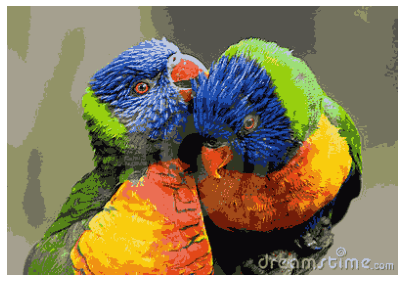

0.7611784699337886


In [22]:
kmeans_clustering_img(20)

Видно, что при количестве кластеров равном 10, картинка начинает походить на первоначальную, визуально, о чём говорит довольно хорошая оценка SSIM(0.67).

Рассмотрим DBSCAN:

In [23]:
from sklearn.cluster import DBSCAN

In [24]:
dbscan = DBSCAN()
y_preds = dbscan.fit_predict(one_dim_img)
centers = dbscan.components_
labels = dbscan.labels_

In [25]:
predict_picture = centers[labels].reshape(275, 400, 3).astype('u1')

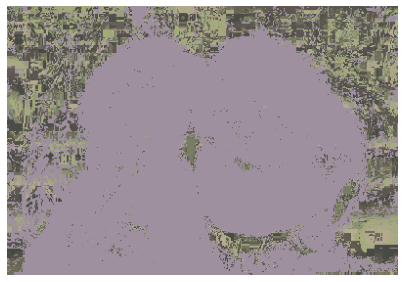

In [26]:
draw_picture(predict_picture)

In [27]:
ssim(img, predict_picture, multichannel=True)

0.10353648647946906

С помощью DBSCAN удалось отделить лишь силуэты, значит для формата RGB он не подходит.

Поработаем с AgglomerativeClustering:

In [34]:
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import AgglomerativeClustering

In [29]:
def agglomerative_clustering_img(n_clust):
  agglcl = AgglomerativeClustering(n_clusters=n_clust)
  y_preds = agglcl.fit_predict(one_dim_img)
  centers = NearestCentroid()
  centers.fit(one_dim_img, y_preds)
  centers = centers.centroids_
  labels = agglcl.labels_

  predict_picture = centers[labels].reshape(275, 400, 3).astype('u1')
  draw_picture(predict_picture)
  print(ssim(img, predict_picture, multichannel=True))

Работает долго, попробуем сжать изображение.

In [57]:
compressed = cv2.resize(img, dsize=(100, 60), interpolation=cv2.INTER_CUBIC)

In [58]:
one_dim_img = compressed.reshape((100 * 60, 3))

In [59]:
def agglomerative_clustering_img(n_clust):
  agglcl = AgglomerativeClustering(n_clusters=n_clust)
  y_preds = agglcl.fit_predict(one_dim_img)
  centers = NearestCentroid()
  centers.fit(one_dim_img, y_preds)
  centers = centers.centroids_
  labels = agglcl.labels_

  predict_picture = centers[labels].reshape(60, 100, 3).astype('u1')
  draw_picture(predict_picture)
  print(ssim(compressed, predict_picture, multichannel=True))

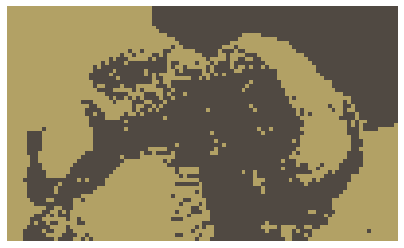

0.4730922772796964


In [60]:
agglomerative_clustering_img(2)

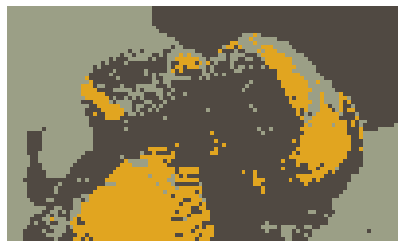

0.5223120967770435


In [61]:
agglomerative_clustering_img(3)

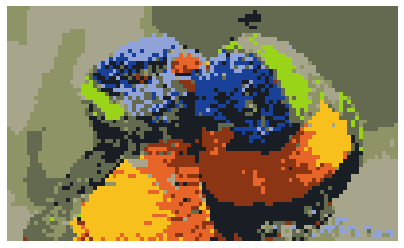

0.6990315984410443


In [62]:
agglomerative_clustering_img(10)

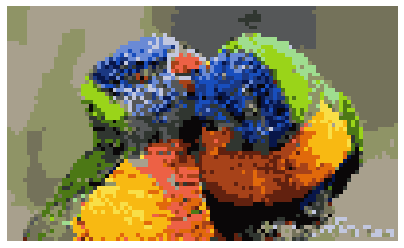

0.8089305244649646


In [63]:
agglomerative_clustering_img(20)

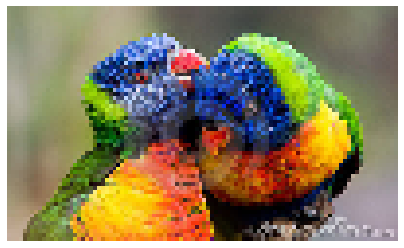

In [64]:
draw_picture(compressed)

При колличестве кластеров равном 20 алгоритм AgglomerativeClustering показывает хорошее качество на оценке SSIM(0.80), и получившаяся картинка визуально походит на сжатую.

**Вывод**



Наилучшим алгоритмом кластеризации для данного формата изображений стал KMeans: он быстро работает, позволяет уменьшить на много порядков уменьшить размерность фото, сохранив при этом хорошее качество.

***Доп. задание: свои картинки:***


In [77]:
cat = cv2.imread('drive/MyDrive/ColabNotebooks/color_cat.jpeg') # считать картинку

In [78]:
print(cat.shape)

(735, 979, 3)


In [79]:
one_dim_cat = cat.reshape(-1, 3)
one_dim_cat.shape

(719565, 3)

In [80]:
def kmeans_clustering_cat(n_clust=2):
  kmeans = KMeans(n_clusters=n_clust)
  y_preds = kmeans.fit_predict(one_dim_cat)
  centers = kmeans.cluster_centers_
  labels = kmeans.labels_
  predict_picture = centers[labels].reshape(735, 979, 3).astype('u1')
  draw_picture(predict_picture)
  print(ssim(cat, predict_picture, multichannel=True))

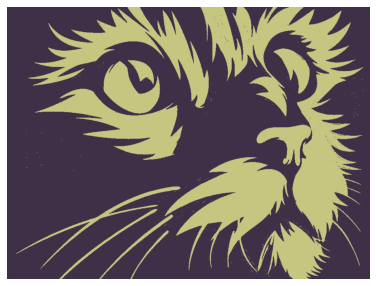

0.4497355109998334


In [81]:
kmeans_clustering_cat(2)

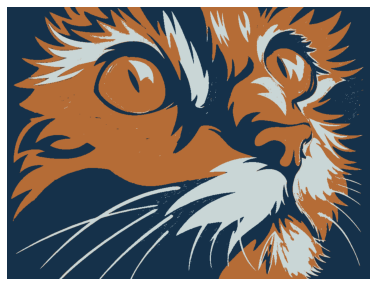

0.4998260899352333


In [82]:
kmeans_clustering_cat(3)

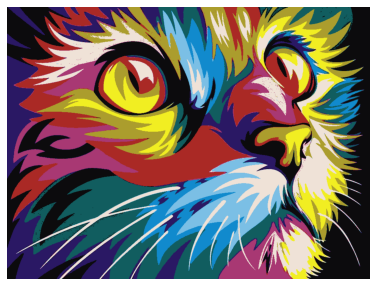

0.7048047012804619


In [83]:
kmeans_clustering_cat(10)

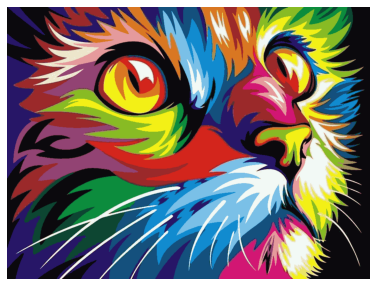

0.770735211185822


In [84]:
kmeans_clustering_cat(20)

Довольно красиво!

In [96]:
art = cv2.imread('drive/MyDrive/ColabNotebooks/art.png')

In [97]:
print(art.shape)

(648, 900, 3)


In [98]:
one_dim_art = art.reshape(-1, 3)


In [99]:
def kmeans_clustering_art(n_clust=2):
  kmeans = KMeans(n_clusters=n_clust)
  y_preds = kmeans.fit_predict(one_dim_art)
  centers = kmeans.cluster_centers_
  labels = kmeans.labels_
  predict_picture = centers[labels].reshape(648, 900, 3).astype('u1')
  draw_picture(predict_picture)
  print(ssim(art, predict_picture, multichannel=True))

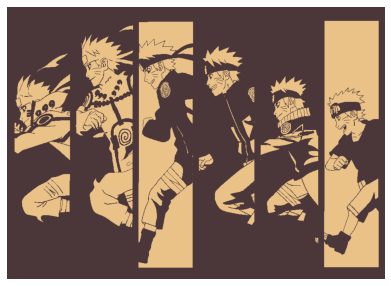

0.5652690442898873


In [106]:
kmeans_clustering_art(2)

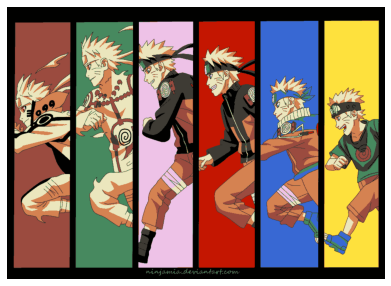

0.9337307191276677


In [102]:
kmeans_clustering_art(10)

# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [2]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [4]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [5]:
y.shape

(2370,)

In [6]:
names[8] # в y лежат номера, а names переводит номер в имя

'George W Bush'

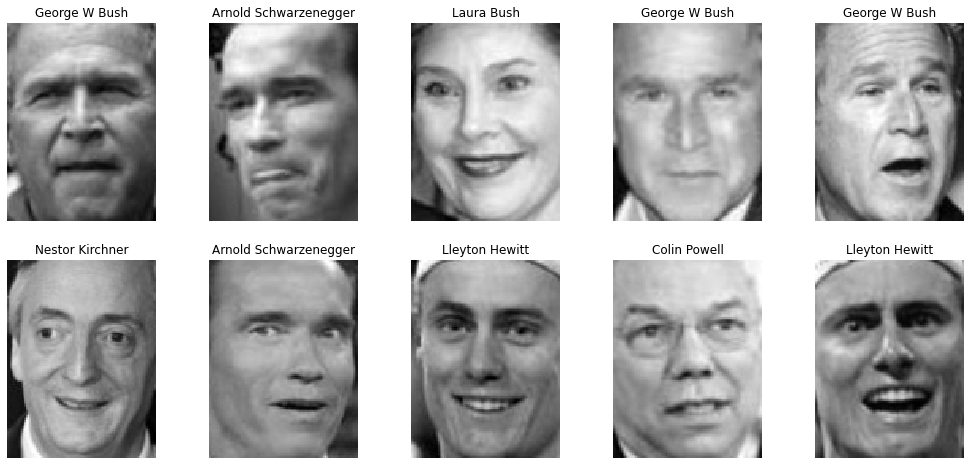

In [71]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

1) Попробуем добиться максимального accuracy
* без уменьшения размерности
* с уменьшением размерности


In [9]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_svd_2 = svd.fit_transform(X)
X_svd_2

array([[12080.787  ,  1621.1848 ],
       [12342.287  ,  1150.7617 ],
       [16473.537  , -2708.708  ],
       ...,
       [14159.401  ,   451.71283],
       [14201.536  ,  3114.811  ],
       [15491.477  ,  -606.7866 ]], dtype=float32)

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca_2 = pca.fit(X).transform(X)
X_pca_2

array([[ 2523.1365   ,  1490.5593   ],
       [ 1973.1495   ,  1064.6765   ],
       [-2402.0427   , -2600.6504   ],
       ...,
       [    4.2976913,   455.3407   ],
       [   45.461956 ,  3124.6948   ],
       [-1250.7363   ,  -555.9719   ]], dtype=float32)

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=400)
X_tsne_2 = tsne.fit_transform(X)
X_tsne_2

array([[-10.482584  ,  19.172026  ],
       [-12.142198  ,  18.998463  ],
       [ -0.68170136, -20.127857  ],
       ...,
       [  5.907848  ,  -8.176906  ],
       [  4.1719317 ,  -4.224892  ],
       [  8.435263  , -14.704276  ]], dtype=float32)

In [7]:
from sklearn.model_selection import cross_val_score

In [8]:
from sklearn.linear_model import LogisticRegression

In [12]:
print('accuracy for raw data is {}'.format(cross_val_score(LogisticRegression(),
                                                           X, y,
                                                           scoring='accuracy').mean()))
print('accuracy for data transormed by SVD-2D is {}'.format(cross_val_score(LogisticRegression(),
                                                                            X_svd_2, y,
                                                                            scoring='accuracy').mean()))
print('accuracy for data transormed by PCA-2D is {}'.format(cross_val_score(LogisticRegression(),
                                                                            X_pca_2, y,
                                                                            scoring='accuracy').mean()))
print('accuracy for data transormed by tSNE-2D is {}'.format(cross_val_score(LogisticRegression(),
                                                                             X_tsne_2, y,
                                                                             scoring='accuracy').mean()))

accuracy for raw data is 0.6780590717299578
accuracy for data transormed by SVD-2D is 0.22362869198312235
accuracy for data transormed by PCA-2D is 0.22995780590717296
accuracy for data transormed by tSNE-2D is 0.23459915611814344


Accuracy без уменьшения размерности равен 0.678. При уменьшении признаков до двух на разных методах удалось достичь accuracy равное 0.23. Попробуем подобрать оптимальную размерность для максимизации accuracy.

In [15]:
import numpy as np

In [26]:
components = np.arange(2, 84, 5)
errors = []

for n_comp in components:
  svd = TruncatedSVD(n_components=n_comp)

  X_svd = svd.fit_transform(X)
  error = cross_val_score(LogisticRegression(), X_svd, y, scoring='accuracy').mean()
  errors.append((n_comp, error))

errors_svd = np.array(errors)

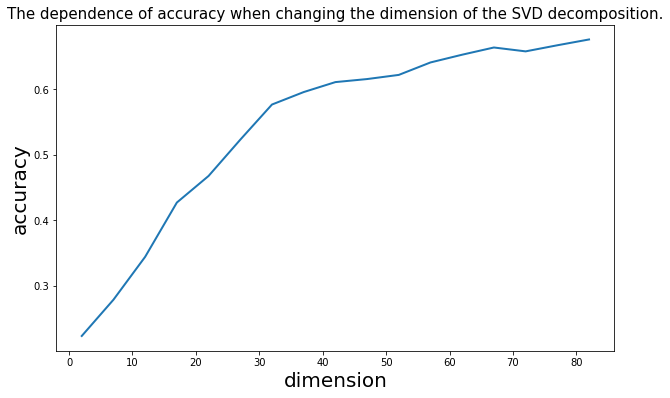

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(errors_svd[:, 0], errors_svd[:, 1], linewidth=2)
plt.title('The dependence of accuracy when changing the dimension of the SVD decomposition.', fontsize=15)
plt.xlabel('dimension', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.show()

In [ ]:
components = np.arange(2, 80, 5)
errors = []

for n_comp in components:
  pca = PCA(n_components=n_comp)

  X_pca = pca.fit(X).transform(X)
  error = cross_val_score(LogisticRegression(), X_pca, y, scoring='accuracy').mean()
  errors.append((n_comp, error))

errors = np.array(errors)

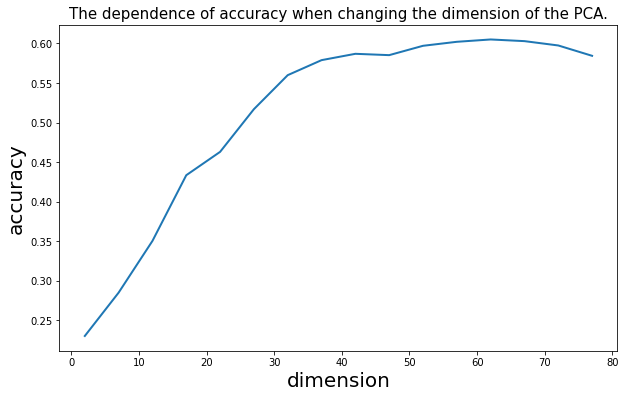

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(errors[:, 0], errors[:, 1], linewidth=2)
plt.title('The dependence of accuracy when changing the dimension of the PCA.', fontsize=15)
plt.xlabel('dimension', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.show()

При уменьшении размерности максимальный accuracy для PCA (0.60) достигается при количестве признаков, равным 60.

Для SVD при размерности 80 accuracy совпадает с первоначальным accuracy (0.67) без уменьшения размерности, что давольно не плохо.

2) **Сравним результат с константным предсказанием "всегда самый популярный класс".**

In [28]:
from collections import Counter

In [31]:
Counter(y)

Counter({0: 39,
         1: 35,
         2: 36,
         3: 77,
         4: 42,
         5: 236,
         6: 31,
         7: 121,
         8: 530,
         9: 109,
         10: 44,
         11: 30,
         12: 39,
         13: 71,
         14: 52,
         15: 55,
         16: 42,
         17: 53,
         18: 31,
         19: 60,
         20: 32,
         21: 41,
         22: 41,
         23: 48,
         24: 33,
         25: 37,
         26: 30,
         27: 32,
         28: 52,
         29: 33,
         30: 33,
         31: 144,
         32: 32,
         33: 49})

In [32]:
names[8]

'George W Bush'

Буш встречается чаще всего в нашей выборке.

In [33]:
y.shape

(2370,)

In [58]:
y_const_pred = np.ones((y_test.shape[0])) * 8
y_const_pred.shape

(474,)

In [59]:
from sklearn.metrics import accuracy_score

In [61]:
print('accuracy for const data is ', accuracy_score(y_test, y_const_pred))

accuracy for const data is  0.23839662447257384


На константном предсказании оценка составляет лишь 0.23. А наша наилучшая модель позволяет увеличить точность в 3 раза!

3) **Нарисуем несколько лиц, на которых наш алгоритм ошибся, подпишим правильный ответ и наш ответ.**

In [104]:
model = LogisticRegression()
svd = TruncatedSVD(n_components=80)
X_svd_80 = svd.fit(X).transform(X)
X_svd_80_train, X_svd_80_test, y_svd_80_train, y_svd_80_test = train_test_split(X_svd_80, y, random_state=42, test_size=0.2)
model.fit(X_svd_80_train, y_svd_80_train)
y_pred = model.predict(X_svd_80_test)
errors = (y_pred != y_svd_80_test)

In [105]:
print('accuracy for svd data is ', accuracy_score(y_svd_80_test, y_pred))

accuracy for svd data is  0.6751054852320675


In [106]:
NUMBER_FACES = 5

plt.figure(figsize=(20, 12))
faces = X_svd_80_test[errors][:NUMBER_FACES]
faces.shape

(5, 80)

<Figure size 1440x864 with 0 Axes>

Правильный ответ:

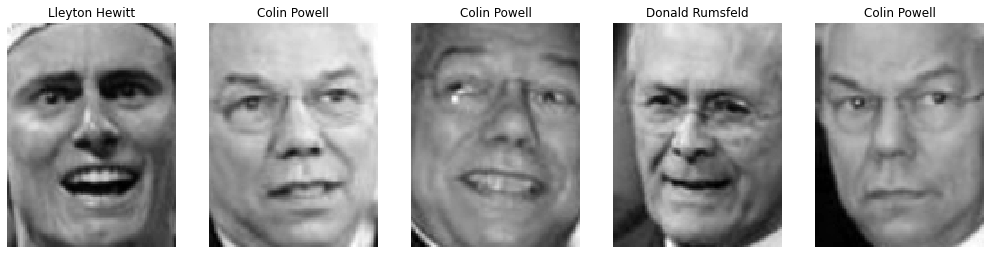

In [107]:
plot_grid(y_svd_80_test[errors][:len(faces)], nrows=1, ncols=5)

In [108]:
# А на самом деле:
y_test[errors][:len(faces)]

array([ 9,  8, 15, 18, 31])

Наш ответ:

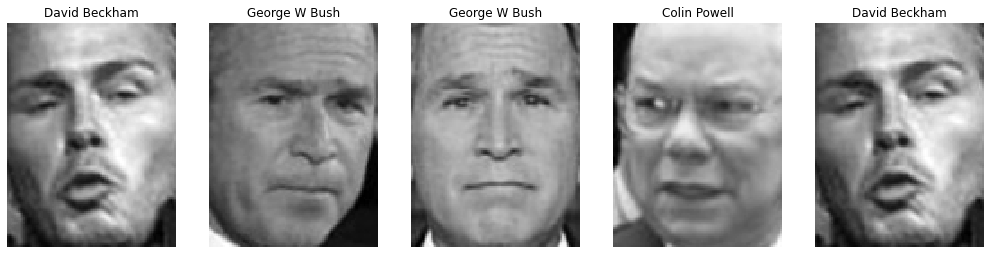

In [109]:
plot_grid(y_pred[errors][:len(faces)], nrows=1, ncols=5)

In [110]:
# Предсказали:
y_pred[errors][:len(faces)]

array([14, 11, 33, 12, 14])

4) Я пользовался алгоритмами PCA и SVD, потому что на них довольно хорошая точность (0.60-0.68). Алгоритм TSNE выдал точность лишь (0.23) так как он может уменьшать данные лишь до размерности 3 или 2, чего в нашей задаче недостаточно из за большой схожести картинок.

5) **Визуализируем датасет на плоскости. Подпишим несколько самых больших классов именами людей. Воспользуемся алгоритмом TSNE, так как у него получилась самая большая точность на размерности два и он отлично визуализирует  2D данные.**

In [126]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, n_iter=1200)
X_tsne_3 = tsne.fit_transform(X)
X_tsne_3

array([[-31.953733 , -40.043324 , -29.200327 ],
       [-41.19103  , -43.575687 , -16.58369  ],
       [ 30.664133 ,  53.835457 ,  43.34504  ],
       ...,
       [ 69.80759  ,  -5.397605 , -19.819098 ],
       [ 29.15656  , -49.631016 , -45.907578 ],
       [ -1.3691242,  34.23924  ,  22.483015 ]], dtype=float32)

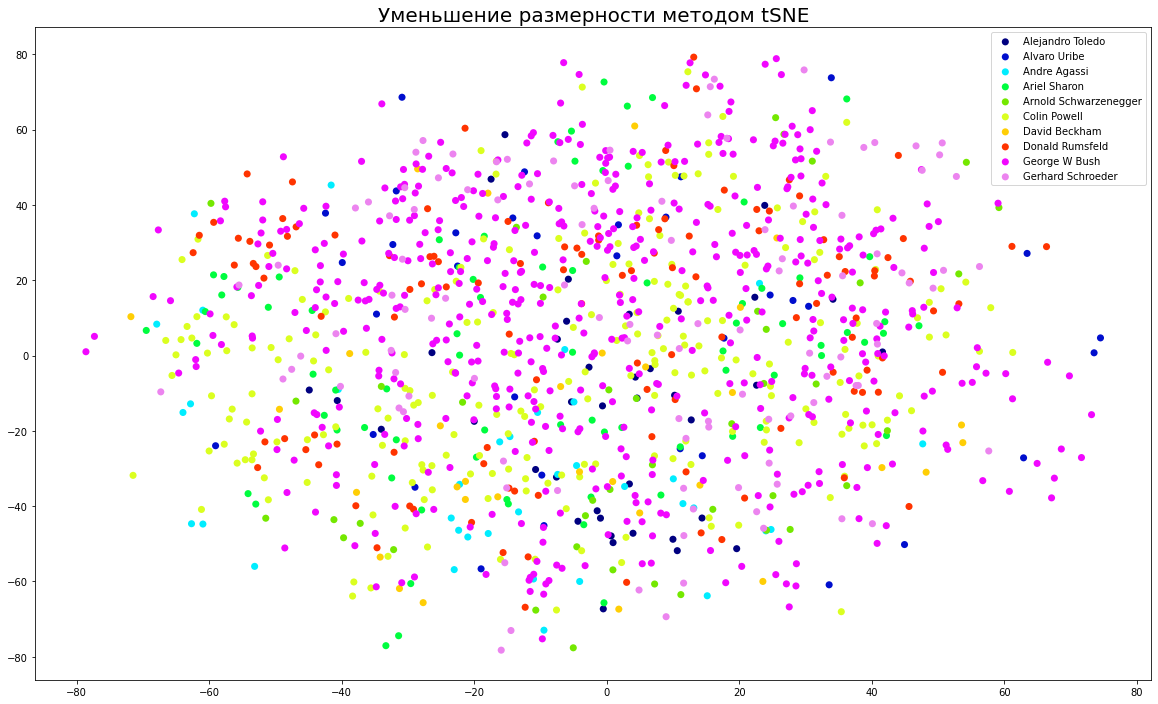

In [127]:
from matplotlib.colors import Normalize


plt.figure(figsize=(20, 12))
for f in range(10):
    norm = Normalize(vmin=0, vmax=10)
    color = plt.cm.gist_ncar(norm(f))
    plt.scatter(X_tsne_3[:, 0][y == f],
                X_tsne_3[:, 1][y == f],
                c=[color] * len(X_tsne_3[:, 0][y == f]), label=names[f], edgecolor='none', s=50)
plt.title(u"Уменьшение размерности методом tSNE", fontsize=20)
plt.legend()

Видно, что Буша действительно очень много, но выделить какой-нибудь конкретный класс довольно проблематично.